# Example1 - Getting started

In this first example we'll take a look at a simple 5 degrees of freedom (DOF) system. 

To access the data and the exact results of the system we can call the ```example_data()``` function under the submodule ```functions.gen```


In [43]:
import os
import sys
import numpy as np
import scipy as sp

# Add the directory we executed the script from to path:
sys.path.insert(0, os.path.realpath('__file__'))

# import the function to generate the example dataset
from pyoma2.functions.gen import example_data

# generate example data and results
data, ground_truth = example_data()

# Print the exact results
np.set_printoptions(precision=3)
print(f"the natural frequencies are: {ground_truth[0]} \n")
print(f"the damping is: {ground_truth[2]} \n")
print("the (column-wise) mode shape matrix: \n"
f"{ground_truth[1]} \n")

data.shape

the natural frequencies are: [0.89  2.598 4.095 5.261 6.   ] 

the damping is: 0.02 

the (column-wise) mode shape matrix: 
[[-0.285 -0.764  1.    -0.919 -0.546]
 [-0.546 -1.     0.285  0.764  0.919]
 [-0.764 -0.546 -0.919  0.285 -1.   ]
 [-0.919  0.285 -0.546 -1.     0.764]
 [-1.     0.919  0.764  0.546 -0.285]] 



(180000, 5)

Load data

In [45]:
import pickle as pk
from EMA_functions import *

EMA_structure = EMA_Structure('no_file')


root_idi = r'D:\thijsmas\MSSP_replication'

test = 11
test_name = 'analysis_' + str(test).zfill(3)
with open(os.path.join(root_idi, 'ndarary_video_pyidi_analysis', test_name,  'points.pkl'), 'rb') as f:
    maxima1d = pk.load(f)
with open(os.path.join(root_idi, 'ndarary_video_pyidi_analysis', test_name, 'results.pkl'), 'rb') as f:
    displacement = pk.load(f)
with open(os.path.join(root_idi, 'ndarary_video_pyidi_analysis', test_name, 'settings.txt'), 'r') as f:
    settings_1d = f.read()
data2 = displacement[:, :, 1].T

fs = 240

n_tracking_points = maxima1d.shape[0]

n = data2.shape[0]

EMA_structure.d = displacement
EMA_structure.points = maxima1d

displacement.shape, data2.shape, n_tracking_points, n

C:\Users\thijsmas\AppData\Local\Temp\ipykernel_3324\1996450685.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  maxima1d = pk.load(f)
C:\Users\thijsmas\AppData\Local\Temp\ipykernel_3324\1996450685.py:14: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access

((500, 1721, 2), (1721, 500), 500, 1721)

(np.int64(456),
 np.int64(499),
 np.int64(498),
 np.int64(499),
 np.int64(500),
 np.int64(458))

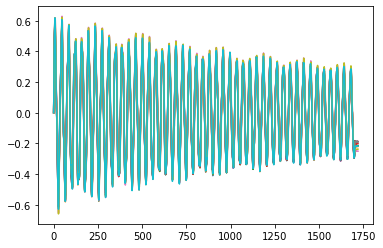

In [46]:
d_lim = 6
d_min = 0.1
smooth_lim = 1
max_drift = 2
max_end_drift = 2

EMA_structure.initialize_displacement(idx='all', dir='xy')
EMA_structure.exclude_tp(d_lim)
EMA_structure.valid_tps = EMA_structure.exclude_high_amplitude & (np.max(np.linalg.norm(EMA_structure.d, axis=2),1) > d_min)

smooth_signals = np.max(np.abs(np.diff(np.linalg.norm(EMA_structure.d, axis=2))), axis = 1) < smooth_lim

non_drifting = np.abs(np.mean(np.linalg.norm(EMA_structure.d[:,:-100], axis=2), axis=1) < max_drift)
non_drifting2 = np.abs(np.linalg.norm(EMA_structure.d[:,-1], axis=1)) < max_end_drift


EMA_structure.valid_tps = EMA_structure.valid_tps  & smooth_signals & non_drifting & non_drifting2

# ani = play_video(video, range(200, 500-1), interval=10, points=td[EMA_structure.valid_tps], axis=([0, video.reader.image_width],[video.reader.image_height, 0]))
%matplotlib inline
fig, ax = plt.subplots()
for d_i in displacement[EMA_structure.valid_tps][:10]:
    ax.plot(d_i[:,1])
EMA_structure.valid_tps.sum(), EMA_structure.exclude_high_amplitude.sum(), smooth_signals.sum() , non_drifting.sum(),  non_drifting2.sum(), (np.max(np.linalg.norm(EMA_structure.d, axis=2),1) > d_min).sum()

In [48]:
%matplotlib qt
window_size = 15  # Define the window size for the rolling average
window = np.ones(window_size) / window_size

fs = 240        # Sampling frequency
dt = 1/fs       # Time step
T = dt*n    # acquisition time

freq = np.fft.rfftfreq(n, dt)
df = fs/n
Displacement = np.fft.rfft(EMA_structure.d[EMA_structure.valid_tps,:,1], n=n, axis=1) / n
Displacement[1:] *= 2
S_xx = 1/T * np.conj(Displacement) * Displacement
S_xx_rolling = sp.ndimage.convolve1d(np.abs(S_xx), window, axis=1, mode='reflect')
peaks_local = []
for S_xx_rolling_i in S_xx_rolling:
    peaks_local.append(find_peaks(np.log10(S_xx_rolling_i), distance=15, prominence=1)[0])
S_xx = np.mean(S_xx, axis=0)
S_xx_rolling = np.mean(S_xx_rolling, axis=0)
peaks_global, _ = find_peaks(np.log10(S_xx_rolling), distance=10, prominence=1)
peaks_global = peaks_global[0]

# Function to check if a value is in an array within a margin
def is_in_array_with_margin(value, array, margin=4):
    return np.any(np.abs(array - value) <= margin)

valid_peaks = np.zeros(len(peaks_local), dtype=bool)
for peak_i, peak in enumerate(peaks_local):
    for p in peak:
        if is_in_array_with_margin(p, peaks_global):
            valid_peaks[peak_i] = True

valid_peaks2 = np.ones(n_tracking_points, dtype=bool)
valid_peaks2[EMA_structure.valid_tps] = valid_peaks
            

print(valid_peaks2.sum(), EMA_structure.valid_tps.sum(), (valid_peaks2 & EMA_structure.valid_tps).sum())

EMA_structure.valid_tps = valid_peaks2 & EMA_structure.valid_tps

500 455 455


Now we can instantiate the ```SingleSetup``` class, passing the dataset and the sampling frequency as arguments

In [49]:
from pyoma2.setup.single import SingleSetup

simp_5dof = SingleSetup(data, fs=200)
simp = SingleSetup(data2[:, EMA_structure.valid_tps], fs=fs)

Since the maximum frequency is at approximately 6Hz, we can decimate the signal quite a bit. To do this we can call the ```decimate_data()``` method

In [50]:
# Decimate the data by factor 10
simp_5dof.decimate_data(q=10)

To analise the data we need to instanciate the desired algorithm to use with a name and the required arguments.

In [51]:
from pyoma2.algorithms.fdd import FDD
from pyoma2.algorithms.fdd import EFDD
from pyoma2.algorithms.ssi import SSIdat
from pyoma2.algorithms.ssi import SSIcov
from pyoma2.algorithms.plscf import pLSCF

# Initialise the algorithms
fdd = FDD(name="FDD", nxseg=1024, method_SD="cor")
efdd = EFDD(name="EFDD", nxseg=1024, method_SD="cor")
ssidat = SSIdat(name="SSIdat", br=30, ordmax=30)
ssicov = SSIcov(name="SSIcov", br=30, ordmax=30)
plscf = pLSCF(name="polymax",ordmax=20)

# Add algorithms to the class
# simp_5dof.add_algorithms(fdd, ssidat)
# run
# simp_5dof.run_all()

# Add algorithms to the class
simp.add_algorithms(fdd, efdd, ssidat,ssicov, plscf)
# simp.run_by_name("polymax")
# run
simp.run_all()

2024-10-04 10:25:49,636 - pyoma2.setup.base - INFO - Running FDD... (base:123)
2024-10-04 10:27:50,640 - pyoma2.setup.base - INFO - Running EFDD... (base:123)
2024-10-04 10:29:48,252 - pyoma2.setup.base - INFO - Running SSIdat... (base:123)
2024-10-04 10:29:48,253 - pyoma2.functions.ssi - INFO - Assembling Hankel matrix method: dat... (ssi:82)
2024-10-04 10:30:07,716 - pyoma2.functions.ssi - INFO - SSI for increasing model order... (ssi:359)
100%|██████████| 31/31 [00:00<00:00, 5224.55it/s]
2024-10-04 10:30:07,846 - pyoma2.functions.ssi - INFO - Calculating modal parameters... (ssi:531)
100%|██████████| 30/30 [00:00<00:00, 1353.02it/s]
2024-10-04 10:30:08,810 - pyoma2.setup.base - INFO - Running SSIcov... (base:123)
2024-10-04 10:30:08,811 - pyoma2.functions.ssi - INFO - Assembling Hankel matrix method: cov_mm... (ssi:82)
2024-10-04 10:36:54,943 - pyoma2.functions.ssi - INFO - SSI for increasing model order... (ssi:359)
100%|██████████| 31/31 [00:00<00:00, 54380.35it/s]
2024-10-04 10:3

We can now check the results

In [21]:
# plot singular values of the spectral density matrix
_, _ = fdd.plot_CMIF(freqlim=(0,120))

# plot singular values of the spectral density matrix
_, _ = efdd.plot_CMIF(freqlim=(0,120))

# plot the stabilisation diagram
_, _ = ssidat.plot_stab(freqlim=(0,120),hide_poles=False)

# plot the stabilisation diagram
_, _ = ssicov.plot_stab(freqlim=(0,120),hide_poles=False)

# plot the stabilisation diagram
_, _ = plscf.plot_stab(freqlim=(0,120),hide_poles=False)



We can get the modal parameters with the help of an interactive plot calling the ```mpe_from_plot method()```, or we can get the results "manually" with the ```MPE()``` method.

In [10]:
# get the modal parameters with the interactive plot
simp.mpe_from_plot("SSIdat", freqlim=(0,120))

# or manually
# simp_5dof.mpe("SSIdat", sel_freq=[0.89, 2.598, 4.095, 5.261, 6.], order="find_min")

2024-10-03 14:53:31,356 - pyoma2.setup.base - INFO - Getting mpe modal parameters from plot... SSIdat (base:171)
2024-10-03 14:53:59,804 - pyoma2.functions.ssi - INFO - Extracting SSI modal parameters (ssi:866)
100%|██████████| 2/2 [00:00<00:00, 1998.72it/s]


Now we can access all the results and compare them to the exact values

In [9]:
# dict of results
ssidat_res = dict(ssidat.result)

# from pyoma2.functions.plot import plot_mac_matrix

# # print the results
# print(f"order out: {ssidat_res['order_out']} \n")
# print(f"the natural frequencies are: {ssidat_res['Fn']} \n")
# print(f"the dampings are: {ssidat_res['Xi']} \n")
# print("the (column-wise) mode shape matrix:")
# print(f"{ssidat_res['Phi'].real} \n")
# _, _ = plot_mac_matrix(ssidat_res['Phi'].real, ground_truth[1])

In [11]:
import numpy as np
import pandas as pd

# Calculate the number of valid points
n_points = EMA_structure.valid_tps.sum()

# Define sensor names as a list of strings
sensor_names = [f"ch{i+1}" for i in range(n_points)]  # Adjusted to match the label format

# Extract the valid points
points = EMA_structure.points[EMA_structure.valid_tps]

# Create a column of zeros with the same number of rows as points
zeros_col = np.zeros((n_points, 1))

# Concatenate the points array with the zeros column as the second column
cor = np.hstack((points[:, 1:], zeros_col, -points[:, 0:1]))

# Convert cor to a pandas DataFrame and set sensor names as the index
sens_coord = pd.DataFrame(cor, columns=["x", "y", "z"], index=sensor_names)

# Create the sens_dir array and convert it to a pandas DataFrame with sensor names as the index
sens_dir = np.tile([1, 0, 0], (n_points, 1))
sens_dir_df = pd.DataFrame(sens_dir, columns=["dx", "dy", "dz"], index=sensor_names)

# Create the sensor names DataFrame
sensor_names_df = pd.DataFrame([sensor_names], columns=[f"chann. {i+1}" for i in range(n_points)])
sensor_names_df.insert(0, "setup No.", [1])

# Combine sensor names and coordinates into a single DataFrame
sensor_coordinates_df = sens_coord.reset_index().rename(columns={"index": "label"})

# Combine sensor names and directions into a single DataFrame
sensor_directions_df = sens_dir_df.reset_index().rename(columns={"index": "label"})

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter("sensor_coordinates.xlsx", engine='xlsxwriter') as writer:
    # Write each DataFrame to a different worksheet
    sensor_names_df.to_excel(writer, sheet_name='sensors names', index=False)
    sensor_coordinates_df.to_excel(writer, sheet_name='sensors coordinates', index=False)
    sensor_directions_df.to_excel(writer, sheet_name='sensors directions', index=False)

In [12]:
import numpy as np
import pandas as pd

# Calculate the number of valid points
n_points = EMA_structure.valid_tps.sum()

# Define sensor names as a list of strings
sensor_names = [f"ch{i+1}" for i in range(n_points)]  # Adjusted to match the label format

# Extract the valid points
points = EMA_structure.points[EMA_structure.valid_tps]

# Create a column of zeros with the same number of rows as points
zeros_col = np.zeros((n_points, 1))

# Concatenate the points array with the zeros column as the second column
cor = np.hstack((points[:, 1:], zeros_col, -points[:, 0:1]))

# Convert cor to a pandas DataFrame and set sensor names as the index
sens_coord = pd.DataFrame(cor, columns=["x", "y", "z"], index=sensor_names)

# Create the sensor names DataFrame
sensor_names_df = pd.DataFrame([sensor_names], columns=[f"chann. {i+1}" for i in range(n_points)])
sensor_names_df.insert(0, "setup No.", [1])

# Create the points coordinates DataFrame
points_coordinates_df = pd.DataFrame(cor, columns=["x", "y", "z"])
points_coordinates_df.insert(0, "ptName", range(1, n_points + 1))

# Create the mapping DataFrame
mapping_data = np.zeros((n_points, 4), dtype=object)
mapping_data[:, 0] = range(1, n_points + 1)
mapping_data[:, 1] = 0
mapping_data[:, 2] = 0
mapping_data[:, 3] = sensor_names[:n_points]
mapping_df = pd.DataFrame(mapping_data, columns=["ptName", "x", "y", "z"])
constraints_df = pd.DataFrame()
# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter("sensor_coordinates2.xlsx", engine='xlsxwriter') as writer:
    # Write each DataFrame to a different worksheet
    sensor_names_df.to_excel(writer, sheet_name='sensors names', index=False)
    points_coordinates_df.to_excel(writer, sheet_name='points coordinates', index=False)
    mapping_df.to_excel(writer, sheet_name='mapping', index=False)
    constraints_df.to_excel(writer, sheet_name='constraints', index=False)

In [15]:
import numpy as np
from pyoma2.algorithms import FSDD, SSIcov, pLSCF
from pyoma2.setup import SingleSetup
from pyoma2.support.utils.sample_data import get_sample_data


simp.def_geo1_by_file("sensor_coordinates.xlsx")
# simp.def_geo2_by_file("sensor_coordinates2.xlsx")
fig, ax = simp.plot_geo1()
_, _ = simp.plot_mode_geo1(algo_res=ssidat.result, mode_nr=1, view="xz", scaleF=20)